# Evaluación

Evaluamos el modelo con la medida AP (Average Precisions ó promedio de precisiones).

Se evalua el modelo en un conjunto de 11 imágenes externas al conjunto de datos original.

In [1]:
# usando gpu 1
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import keras
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

Using TensorFlow backend.
/home/aalejo/anaconda3/envs/dl/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/aalejo/anaconda3/envs/dl/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/aalejo/anaconda3/envs/dl/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/aalejo/anaconda3/envs/dl/l

In [2]:
from keras import backend as K
from keras.models import load_model
from keras.optimizers import Adam
#from scipy.misc import imread
from imageio import imread
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd512 import ssd_512
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization
from data_generator.object_detection_2d_data_generator import DataGenerator
from eval_utils.average_precision_evaluator import Evaluator

%matplotlib inline

In [3]:
# Parametros de configuracion
img_height = 512
img_width = 512
n_classes = 1
#model_mode = 'inference'
model_mode = 'training'

## Cargando el modelo entrenado

In [4]:
# Cargamos el modelo guardado en la época 120
model_path = 'ssd512_whales_epoch-120.h5'

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session()

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'DecodeDetections': DecodeDetections,
                                               'compute_loss': ssd_loss.compute_loss})

model.summary()


tracking <tf.Variable 'conv4_3_norm/conv4_3_norm_gamma:0' shape=(512,) dtype=float32> gamma

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_mean_normalization (Lambd (None, 512, 512, 3)  0           identity_layer[0][0]             
_

## Creando el  data generator para el dataset de evaluación

In [5]:
dataset = DataGenerator()

#whales_images_dir_train = '../ssd_keras/datasets/whales/train/train/'
whales_images_dir_test = '../ssd_keras/datasets/whales/test/test2/'
whales_annotations_dir = '../ssd_keras/datasets/whales/annotations/' 
#whales_train_image_set_filename = '../ssd_keras/datasets/whales/train.txt' 
#whales_val_image_set_filename = '../ssd_keras/datasets/whales/val.txt' 
whales_test_image_set_filename = '../ssd_keras/datasets/whales/test.txt'

classes = ['background','whale']

dataset.parse_xml(images_dirs=[whales_images_dir_test],
                  image_set_filenames=[whales_test_image_set_filename],
                  annotations_dirs=[whales_annotations_dir],
                  classes=classes,
                  include_classes='all',
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False)

Processing image set 'test.txt': 100%|██████████| 39/39 [00:00<00:00, 261.11it/s]


In [6]:
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_geometric_ops import Resize

convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# Definiendo el generador de predicciones
predict_generator = dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[convert_to_3_channels,
                                                          resize],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'filenames',
                                                  'inverse_transform',
                                                  'original_images',
                                                  'original_labels'},
                                         keep_images_without_gt=False)

In [7]:
batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)

i = 0 # indice del batch 

print("Imagen:", batch_filenames[i])
print()
print("Cuadro deliminator verdadero:\n")
print(np.array(batch_original_labels[i]))

Imagen: ../ssd_keras/datasets/whales/test/test2/0d86f408.jpg

Cuadro deliminator verdadero:

[[  1 360 268 677 387]]


In [8]:
y_pred = model.predict(batch_images)

y_pred

array([[[ 9.9423593e-01,  5.7641394e-03,  7.2144639e-01, ...,
          1.0000000e-01,  2.0000000e-01,  2.0000000e-01],
        [ 9.9398983e-01,  6.0102502e-03, -2.5681067e-01, ...,
          1.0000000e-01,  2.0000000e-01,  2.0000000e-01],
        [ 9.9371088e-01,  6.2890854e-03,  6.4984369e-01, ...,
          1.0000000e-01,  2.0000000e-01,  2.0000000e-01],
        ...,
        [ 9.9937552e-01,  6.2446494e-04, -5.2530922e-02, ...,
          1.0000000e-01,  2.0000000e-01,  2.0000000e-01],
        [ 9.9915993e-01,  8.4013370e-04, -1.0632612e-02, ...,
          1.0000000e-01,  2.0000000e-01,  2.0000000e-01],
        [ 9.9987054e-01,  1.2941705e-04,  1.5510452e-01, ...,
          1.0000000e-01,  2.0000000e-01,  2.0000000e-01]]], dtype=float32)

In [9]:
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast
normalize_coords = True

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.4,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

y_pred_decoded

[array([[  1.        ,   0.91171622, 183.3989563 , 201.32470703,
         324.12158203, 271.51654053]])]

In [10]:
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

y_pred_decoded_inv = apply_inverse_transforms(y_pred_decoded, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Cuadro predecido:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded_inv[i])

Cuadro predecido:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.91 376.   275.   665.   371.  ]]


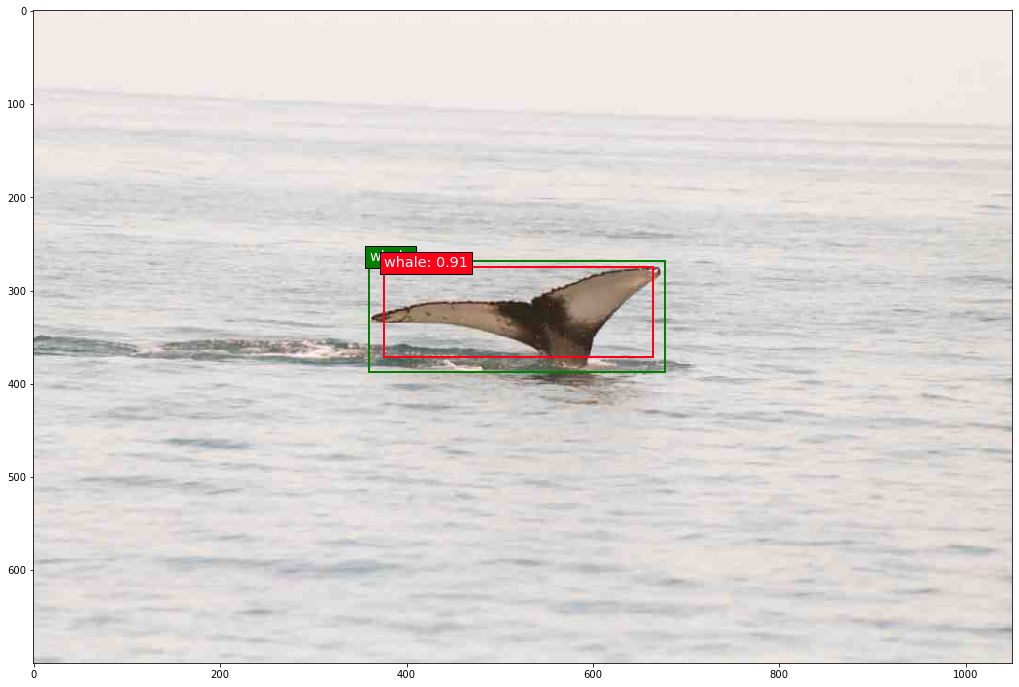

In [11]:

colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background','whale']

plt.figure(figsize=(20,12))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_decoded_inv[i]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

## Evaluando

Se calcula el AP según el algoritmo de Pascal VOC pre-10

In [12]:
evaluator = Evaluator(model=model,
                      n_classes=n_classes,
                      data_generator=dataset,
                      model_mode=model_mode)

results = evaluator(img_height=img_height,
                    img_width=img_width,
                    batch_size=8,
                    data_generator_mode='resize',
                    round_confidences=False,
                    matching_iou_threshold=0.5,
                    border_pixels='include',
                    sorting_algorithm='quicksort',
                    average_precision_mode='sample',
                    num_recall_points=11,
                    ignore_neutral_boxes=True,
                    return_precisions=True,
                    return_recalls=True,
                    return_average_precisions=True,
                    verbose=True)

mean_average_precision, average_precisions, precisions, recalls = results

Number of images in the evaluation dataset: 39

Matching predictions to ground truth, class 1/1.: 100%|██████████| 151/151 [00:00<00:00, 5138.54it/s]
Computing precisions and recalls, class 1/1
Computing average precision, class 1/1


## Mostrando los resulados

In [13]:
for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

whale         AP    0.854

              mAP   0.854


Text(0.5, 1.0, 'whale, AP: 0.854')

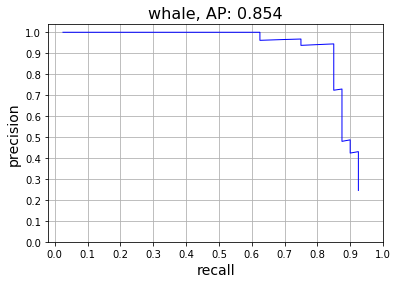

In [14]:
m = 1
n = 1

#fig, cells = plt.subplots(m, n, figsize=(n*8,m*8))
plt.plot(recalls[n], precisions[n], color='blue', linewidth=1.0)
plt.xlabel('recall', fontsize=14)
plt.ylabel('precision', fontsize=14)
plt.grid(True)
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.title("{}, AP: {:.3f}".format(classes[1], average_precisions[1]), fontsize=16)        